In [3]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

In [14]:
train=pd.read_csv("train.csv")
test=pd.read_csv(r"test.csv")
submission = pd.read_csv("submission.csv")

In [15]:
train.head() #train starts at 2020-01-22

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [16]:
train.tail()   #train ends at 2020-03-31

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
22639,32705,NaN,Zimbabwe,2020-03-31,8.0,1.0
22640,32706,NaN,Zimbabwe,2020-04-01,8.0,1.0
22641,32707,NaN,Zimbabwe,2020-04-02,9.0,1.0
22642,32708,NaN,Zimbabwe,2020-04-03,9.0,1.0
22643,32709,NaN,Zimbabwe,2020-04-04,9.0,1.0


In [17]:
test.head()   #test starts at 2020-03-26 (so, ideally, testing should be 03-26 to present)

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-03-26
1,2,NaN,Afghanistan,2020-03-27
2,3,NaN,Afghanistan,2020-03-28
3,4,NaN,Afghanistan,2020-03-29
4,5,NaN,Afghanistan,2020-03-30


In [22]:
#to group the csv by country
def group_country(train_data):
    new_train = train_data.fillna('NA').groupby(['Country_Region','Province_State','Date'])['ConfirmedCases'].sum() \
                          .groupby(['Country_Region','Province_State']).max().sort_values() \
                          .groupby(['Country_Region']).sum().sort_values(ascending = False)
    return new_train
country__sum = group_country(train)

In [77]:
def group_country_date(train_data):
    new_train = pd.DataFrame(train_data.fillna('NA').groupby(['Country_Region','Date'])['ConfirmedCases'].sum().sort_values().reset_index())
    new_train = pd.DataFrame(new_train)
    new_train = new_train.sort_values(by=['Country_Region'])
    return new_train
country_sum_d = group_country_date(train)
country_sum_d

,Country_Region,Date,ConfirmedCases
0,Afghanistan,2020-01-22,0.0
5456,Afghanistan,2020-02-12,0.0
5458,Afghanistan,2020-02-10,0.0
5459,Afghanistan,2020-02-09,0.0
5460,Afghanistan,2020-02-08,0.0
...,...,...,...
5415,Zimbabwe,2020-03-05,0.0
5416,Zimbabwe,2020-03-04,0.0
5427,Zimbabwe,2020-02-15,0.0
5429,Zimbabwe,2020-02-17,0.0


In [78]:
country_sum_d.to_csv("country_by_date.csv")

In [54]:
def country_spec_date (country_name, data):
    new_train = data.loc[(data['Country_Region'] == country_name)]
    return new_train

US_data = country_spec_date("US",country_sum_d)

In [63]:
def growth_country_date (country_name,data,column_name):
    new_train = data.loc[(data['Country_Region'] == country_name)]
    new_train[column_name+' growth'] = new_train[column_name].diff()
    new_train 
    return new_train

confirmed_growth_US = growth_country_date("US",US_data,'ConfirmedCases')
confirmed_growth_US.head()

,Country_Region,Date,ConfirmedCases,ConfirmedCases growth
4733,US,2020-01-22,0.0,NaN
4734,US,2020-01-23,0.0,0.0
4735,US,2020-01-24,0.0,0.0
4736,US,2020-01-25,0.0,0.0
4737,US,2020-01-26,0.0,0.0


(737446.0, 737546.0)

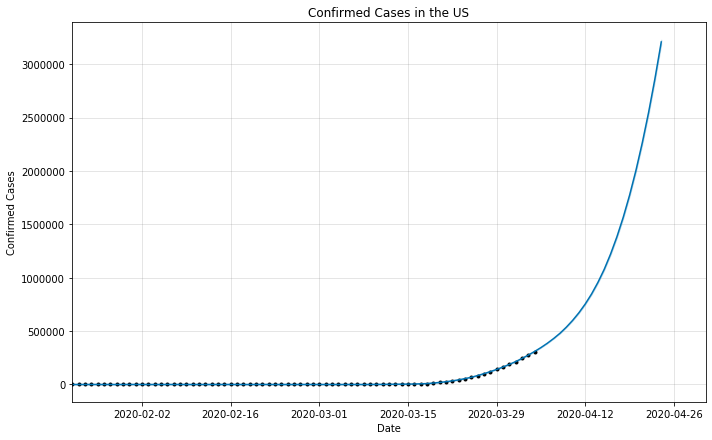

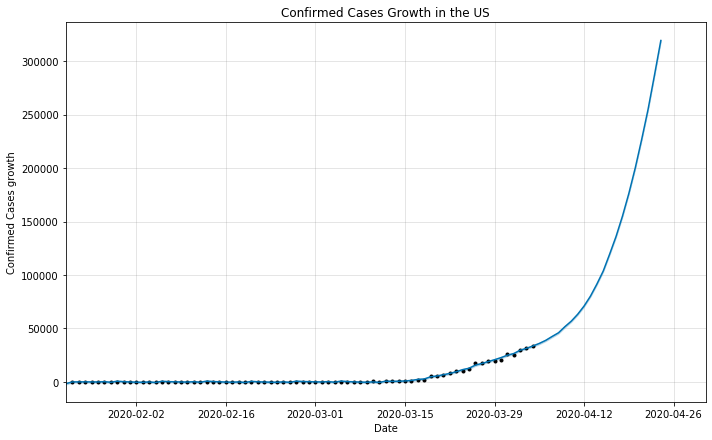

In [72]:
#below is from fbprophet
from datetime import datetime, timedelta
from fbprophet import Prophet
m1 = Prophet(changepoint_prior_scale=0.15, yearly_seasonality=True, daily_seasonality=True)
m2 = Prophet(changepoint_prior_scale=0.15, yearly_seasonality=True, daily_seasonality=True)

def prophet_model (train_data, column_name, model) :
    train_prophet = train_data[[column_name, 'Date']]
    train_prophet = train_prophet.rename(columns={'Date': 'ds', column_name: 'y'})
    model.fit(train_prophet)
    future = model.make_future_dataframe(periods=20, freq='D')
    forecast = model.predict(future)
    return forecast

f = prophet_model(US_data, 'ConfirmedCases',m1)
m1.plot(f, xlabel = 'Date', ylabel = 'Confirmed Cases')
plt.title('Confirmed Cases in the US')
plt.xlim(datetime(2020,1,22), datetime(2020,5,1))

f2 = prophet_model(confirmed_growth_US,'ConfirmedCases growth',m2)
m2.plot(f2, xlabel = 'Date', ylabel = 'Confirmed Cases growth')
plt.title('Confirmed Cases Growth in the US')
plt.xlim(datetime(2020,1,22), datetime(2020,5,1))


# fig1 = m.plot(forecast)
#fig2 = m.plot_components(forecast)